### Importando bibliotecas


In [73]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import warnings
import seaborn as sns

# Importing Libraries for the model ,Tfidf and Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

import contractions # contrations é o pacote em python usado para expandir as contrações no idioma inglês para sua forma original. Exemplo: I'll to "I will"
from tqdm import tqdm # O pacote tqdm é usado para acompanhar o andamento do trabalho. Ele exibe a porcentagem de loop concluído.
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer

from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

plt.style.use('fivethirtyeight')
warnings.simplefilter("ignore")


**Processamento de Linguagem Natural ou PNL** é um ramo da Inteligência Artificial que trata de fazer a ponte entre as máquinas que entendem os humanos em sua Linguagem Natural. A linguagem natural pode ser na forma de texto ou som, que são usados para que os humanos se comuniquem. A PNL pode permitir que os humanos se comuniquem com as máquinas de uma forma natural.

**Classificação de Texto** é um processo envolvido na Análise de Sentimento. É a classificação da opinião ou expressão das pessoas em diferentes sentimentos. Os sentimentos incluem Positivo, Neutro e Negativo, Avaliações de Avaliações e Feliz, Triste. A Análise de Sentimento pode ser feita em diferentes setores centrados no consumidor para analisar a opinião das pessoas sobre um determinado produto ou assunto.

O processamento de linguagem natural tem suas raízes na década de 1950. Já em 1950, Alan Turing publicou um artigo intitulado "Computing Machinery and Intelligence" que propunha o que hoje é chamado de teste de Turing como critério de inteligência, tarefa que envolve a interpretação e geração automatizada de linguagem natural, mas na época não articulada como um problema separado da inteligência artificial.


## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">Índice</p>

- [1. Carregando dos dados 💎](#1)
- [2. EDA 📊](#2)
- [3. Pré-processamento de dados ⚙️](#3)
  - [3.1 Dados ausentes e duplicados 🛠](#3.1)
  - [3.2 Balanceamento dos dados 🛠](#3.2)
  - [3.3 Limpando o corpus 🛠](#3.3)
  - [3.4 Lematização 🛠](#3.4)
  - [3.5 Todos juntos 🛠](#3.5)
  - [3.6 Codificação de destino 🛠](#3.6)
- [4. Visualização de tokens 📊](#4)
- [5. Vetorização e Modelagem](#5)
  - [5.2 TF-IDF](#5.1)
  - [5.2 Word2Vec](#5.2)
  - [5.2 BERT](#5.3)


<a id='1'></a>

# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">1. Carregando dados 💎</p>


In [74]:
df= pd.read_csv("Dados/Phishing_Email.csv")
df.head()

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [75]:
df['message_len'] = df['Email Text'].apply(lambda x: len(x.split(' ')) if not pd.isna(x) else 0)
df.head()

,Email Text,Email Type,message_len
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,230
1,the other side of * galicismos * * galicismo *...,Safe Email,91
2,re : equistar deal tickets are you still avail...,Safe Email,305
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,146
4,software at incredibly low prices ( 86 % lower...,Phishing Email,91


In [76]:
max(df['message_len'])

3527576

<a id='2'></a>

# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">2. EDA 📊</p>

Agora vamos dar uma olhada no tipo de email e no comprimento das mensagens.


**Conjunto de dados balanceado:** — Vamos dar um exemplo simples se em nosso conjunto de dados tivermos valores positivos que são aproximadamente iguais aos valores negativos. Então podemos dizer que nosso conjunto de dados está equilibrado.

![balanced-dataset.png](\img\balanced-dataset.png)

Considere a cor laranja como um valor positivo e a cor azul como um valor negativo. Podemos dizer que o número de valores positivos e valores negativos é aproximadamente o mesmo.

**Conjunto de dados desequilibrado:** — Se houver uma diferença muito alta entre os valores positivos e os valores negativos. Então podemos dizer nosso conjunto de dados em Imbalance Dataset.

![imbalanced-dataset.png](\img\imbalanced-dataset.png)


In [77]:
balance_counts = df.groupby('Email Type')['Email Type'].agg('count').values
balance_counts

array([ 7328, 11322], dtype=int64)

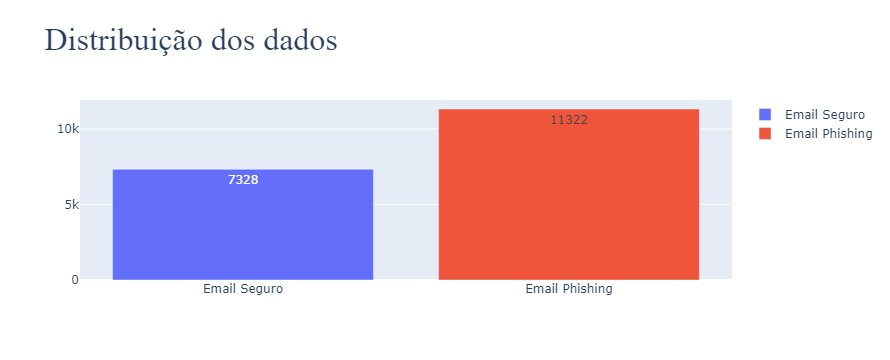

In [78]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Email Seguro'],
    y=[balance_counts[0]],
    name='Email Seguro',
    text=[balance_counts[0]],
    textposition='auto',
))
fig.add_trace(go.Bar(
    x=['Email Phishing'],
    y=[balance_counts[1]],
    name='Email Phishing',
    text=[balance_counts[1]],
    textposition='auto',
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Distribuição dos dados</span>'
)
fig.show()

Como podemos ver, as classes estão desequilibradas, então podemos considerar o uso de algum tipo de reamostragem.


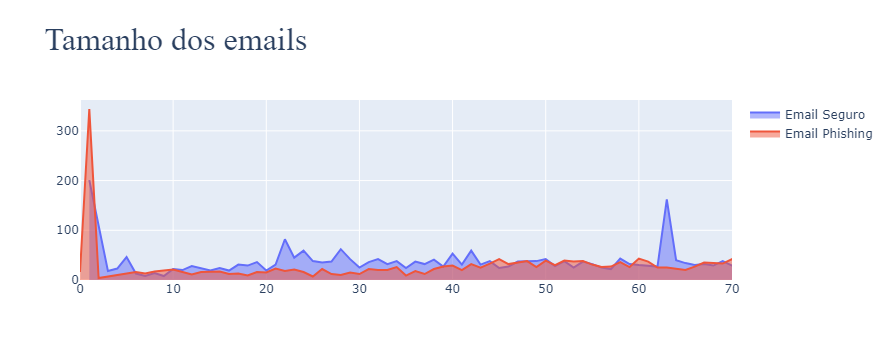

In [79]:
ham_df = df[df['Email Type'] == 'Safe Email']['message_len'].value_counts().sort_index()
spam_df = df[df['Email Type'] == 'Phishing Email']['message_len'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=ham_df.index,
    y=ham_df.values,
    name='Email Seguro',
    fill='tozeroy',
))
fig.add_trace(go.Scatter(
    x=spam_df.index,
    y=spam_df.values,
    name='Email Phishing',
    fill='tozeroy',
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Tamanho dos emails</span>'
)
fig.update_xaxes(range=[0, 70])
fig.show()

Como podemos ver, o comprimento da mensagem `Email Seguro` tende a ser menor que o comprimento da mensagem `Email Phishing`.


<a id='3'></a>

# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">3. Pré-processamento de dados 🛠</p>

Agora vamos tratar os dados para facilitar a classificação do modelo.

Esta seção é muito importante para reduzir as dimensões do problema.


<a id='3.1'></a>

## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">3.1 Dados ausentes e duplicados 🛠</p>


In [80]:
# Verificando dados ausentes
df.isna().sum()

Email Text     16
Email Type      0
message_len     0
dtype: int64

In [81]:
# Removendo valores ausentes
df = df.dropna()

In [82]:
# Verificando dados duplicados
df.duplicated().sum()

1096

In [83]:
# Removendo os dados duplicados
df = df.drop_duplicates(keep = 'first')

<a id='3.2'></a>

## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">3.2 Balanceamento dos dados 🛠</p>


In [84]:
Safe_Email = df[df["Email Type"]== "Safe Email"]
Phishing_Email = df[df["Email Type"]== "Phishing Email"]
Safe_Email = Safe_Email.sample(Phishing_Email.shape[0])

In [85]:
Safe_Email.shape,Phishing_Email.shape

((6558, 3), (6558, 3))

In [86]:
df = pd.concat([Safe_Email, Phishing_Email], ignore_index = True)
df.head()

,Email Text,Email Type,message_len
0,"On 24 Jul 2002, Karl Anderson wrote:--]An inte...",Safe Email,160
1,We have a partnership with Webex. We use thei...,Safe Email,992
2,"re : yes , would you like me to call you ? - -...",Safe Email,146
3,schedule crawler : hourahead failure start dat...,Safe Email,28
4,start date : 1 / 12 / 02 ; hourahead hour : 12...,Safe Email,63


<a id='3.3'></a>

## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">3.3 Limpando o corpus 🛠</p>


In [15]:
def clean_text(text):
    '''Tornar o texto em minúsculas, remover o texto entre colchetes, remover links, remover pontuação
     e remova palavras que contenham números.'''
    # Expressão regular que remove todas as tags html presentes nas avaliações
    text = re.sub('(<[\w\s]*/?>)',"",text)
    # Removendo as URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    # Expandindo todas as contrações presentes na revisão para sua respectiva forma real
    text = contractions.fix(text)
    # Removendo todos os caracteres especiais do texto da revisão (Pontuação)
    text = re.sub('[^a-zA-Z0-9\s]+',"",text)
    # Removendo todos os dígitos presentes no texto da revisão
    text = re.sub('\w*\d\w*', '', text)
    # Removendo quebra de linha
    text = re.sub('\n', '', text)
    return text

In [16]:
df['Email Text Clean'] = df['Email Text'].apply(clean_text)
df.head()

,Email Text,Email Type,message_len,Email Text Clean
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,230,re disc uniformitarianism re sex la...
1,the other side of * galicismos * * galicismo *...,Safe Email,91,the other side of galicismos galicismo is ...
2,re : equistar deal tickets are you still avail...,Safe Email,305,re equistar deal tickets are you still availa...
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,146,Hello I am your hot lil horny toy I am the ...
4,software at incredibly low prices ( 86 % lower...,Phishing Email,91,software at incredibly low prices lower d...


### Stopwords

Stopwords são palavras comumente usadas em inglês que não têm significado contextual em uma frase. Portanto, nós os removemos antes da classificação. Alguns exemplos de remoção de Stopwords são:

![stopwords.png](\img\stopwords.png)


In [17]:
# Baixando as stopwords da língua inglesa
nltk.download('stopwords')

# Carregando as stopwords
stopwords=stopwords.words('english')

# Adicionando mais stopwrods
stopwords+=['enron', 'email', 'u', 'im', 'c', 'mail']

[nltk_data] Downloading package stopwords to C:\Users\Marcos
[nltk_data]     Eduardo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stopwords)
    return text
    
df['Email Text Clean'] = df['Email Text Clean'].apply(remove_stopwords)
df.head()

,Email Text,Email Type,message_len,Email Text Clean
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,230,disc uniformitarianism sex lang dic...
1,the other side of * galicismos * * galicismo *...,Safe Email,91,side galicismos galicismo spanish term nam...
2,re : equistar deal tickets are you still avail...,Safe Email,305,equistar deal tickets still available assist ...
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,146,Hello I hot lil horny toy I one dream About...
4,software at incredibly low prices ( 86 % lower...,Phishing Email,91,software incredibly low prices lower drap...


<a id='3.4'></a>

## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">3.4 Stemming 🛠</p>

### Stemming/ Lematization

Por razões gramaticais, os documentos usarão diferentes formas de palavra, como _escrever, escrevendo e escreveu_. Além disso, existem famílias de palavras relacionadas derivacionalmente com significados semelhantes. O objetivo da lematização e da lematização é reduzir as formas flexionais e, às vezes, as formas derivacionalmente relacionadas de uma palavra a uma forma de base comum.

**Stemming** geralmente se refere a um processo que corta o final das palavras na esperança de atingir o objetivo corretamente na maioria das vezes e geralmente inclui a remoção de afixos derivacionais.

**Lematização** geralmente se refere a fazer as coisas corretamente com o uso de vocabulário e análise morfológica de palavras, normalmente com o objetivo de remover apenas terminações flexionais e retornar a base e a forma de dicionário de uma palavra

![stemm-lemmatization.png](\img\stemm-lemmatization.png)

Na medida em que o significado das palavras não é importante para este estudo, focaremos na lematização e não na lematização.

### Algoritmos de Stemming

Existem vários algoritmos de lematização implementados na biblioteca NLTK Python:

1. **PorterStemmer** usa _Suffix Stripping_ para produzir hastes. **PorterStemmer é conhecido por sua simplicidade e velocidade**. Observe como o PorterStemmer está fornecendo a raiz (radical) da palavra "gatos" simplesmente removendo o 's' depois de gato. Este é um sufixo adicionado a gato para torná-lo plural. Mas se você olhar para 'problema', 'problemação' e 'problemático', eles são derivados de 'problema' porque o algoritmo _PorterStemmer não segue a linguística, mas sim um conjunto de 05 regras para diferentes casos que são aplicadas em fases (passo a passo) para gerar hastes_. Esta é a razão pela qual o PorterStemmer nem sempre gera radicais que sejam palavras reais em inglês. Ele não mantém uma tabela de pesquisa para radicais reais da palavra, mas aplica regras algorítmicas para gerar radicais. Ele usa as regras para decidir se é aconselhável retirar um sufixo.
2. É possível gerar seu próprio conjunto de regras para qualquer linguagem, por isso o Python nltk introduziu **SnowballStemmers** que são usados para criar Stemmers em idiomas diferentes do inglês!
3. **LancasterStemmer** (Paice-Husk stemmer) é um algoritmo iterativo com regras salvas externamente. Uma tabela contendo cerca de 120 regras indexadas pela última letra de um sufixo. A cada iteração, tenta encontrar uma regra aplicável pelo último caractere da palavra. Cada regra especifica uma exclusão ou substituição de um final. Se não existir tal regra, ela termina. Também termina se uma palavra começar com uma vogal e restarem apenas duas letras ou se uma palavra começar com uma consoante e restarem apenas três caracteres. Caso contrário, a regra é aplicada e o processo se repete.


In [19]:
stemmer = SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [20]:
df['Email Text Clean'] = df['Email Text Clean'].apply(stemm_text)
df.head()

,Email Text,Email Type,message_len,Email Text Clean
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,230,disc uniformitarian sex lang dick h...
1,the other side of * galicismos * * galicismo *...,Safe Email,91,side galicismo galicismo spanish term name...
2,re : equistar deal tickets are you still avail...,Safe Email,305,equistar deal ticket still avail assist rober...
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,146,hello i hot lil horni toy i one dream about...
4,software at incredibly low prices ( 86 % lower...,Phishing Email,91,softwar incred low price lower draperi se...


In [1]:
!pip install black

Defaulting to user installation because normal site-packages is not writeable


<a id='3.5'></a>

## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">3.5 Todos juntos 🛠</p>


In [21]:
def preprocess_data(text):
    # Limpando pontuação, urls, e etc
    text = clean_text(text)
    # Removendo stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stopwords)
    # Stemm todas as palavras do email
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    
    return text

In [22]:
df['Email Text Clean'] = df['Email Text Clean'].apply(preprocess_data)
df.head()

,Email Text,Email Type,message_len,Email Text Clean
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,230,disc uniformitarian sex lang dick h...
1,the other side of * galicismos * * galicismo *...,Safe Email,91,side galicismo galicismo spanish term name...
2,re : equistar deal tickets are you still avail...,Safe Email,305,equistar deal ticket still avail assist rober...
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,146,hello hot lil horni toy one dream open m...
4,software at incredibly low prices ( 86 % lower...,Phishing Email,91,softwar incr low price lower draperi seve...


<a id='3.6'></a>

## <p style="background-color:skyblue; font-family:newtimeroman; font-size:140%; text-align:center; border-radius: 15px 50px;">3.6 Codificação do tipo de email 🛠</p>


In [23]:
encoder = {'Phishing Email': 1, 'Safe Email': 0}

df['Email Type Encoded'] = df['Email Type'].map(encoder)
df.head()

,Email Text,Email Type,message_len,Email Text Clean,Email Type Encoded
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,230,disc uniformitarian sex lang dick h...,0
1,the other side of * galicismos * * galicismo *...,Safe Email,91,side galicismo galicismo spanish term name...,0
2,re : equistar deal tickets are you still avail...,Safe Email,305,equistar deal ticket still avail assist rober...,0
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email,146,hello hot lil horni toy one dream open m...,1
4,software at incredibly low prices ( 86 % lower...,Phishing Email,91,softwar incr low price lower draperi seve...,1


<a id='4'></a>

# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">4. Visualização de tokens 📊</p>


In [24]:
# pip install wordcloud
from wordcloud import WordCloud

In [25]:
spam_df = df[df['Email Type']=='Phishing Email']
ham_df = df[df['Email Type']=='Safe Email']

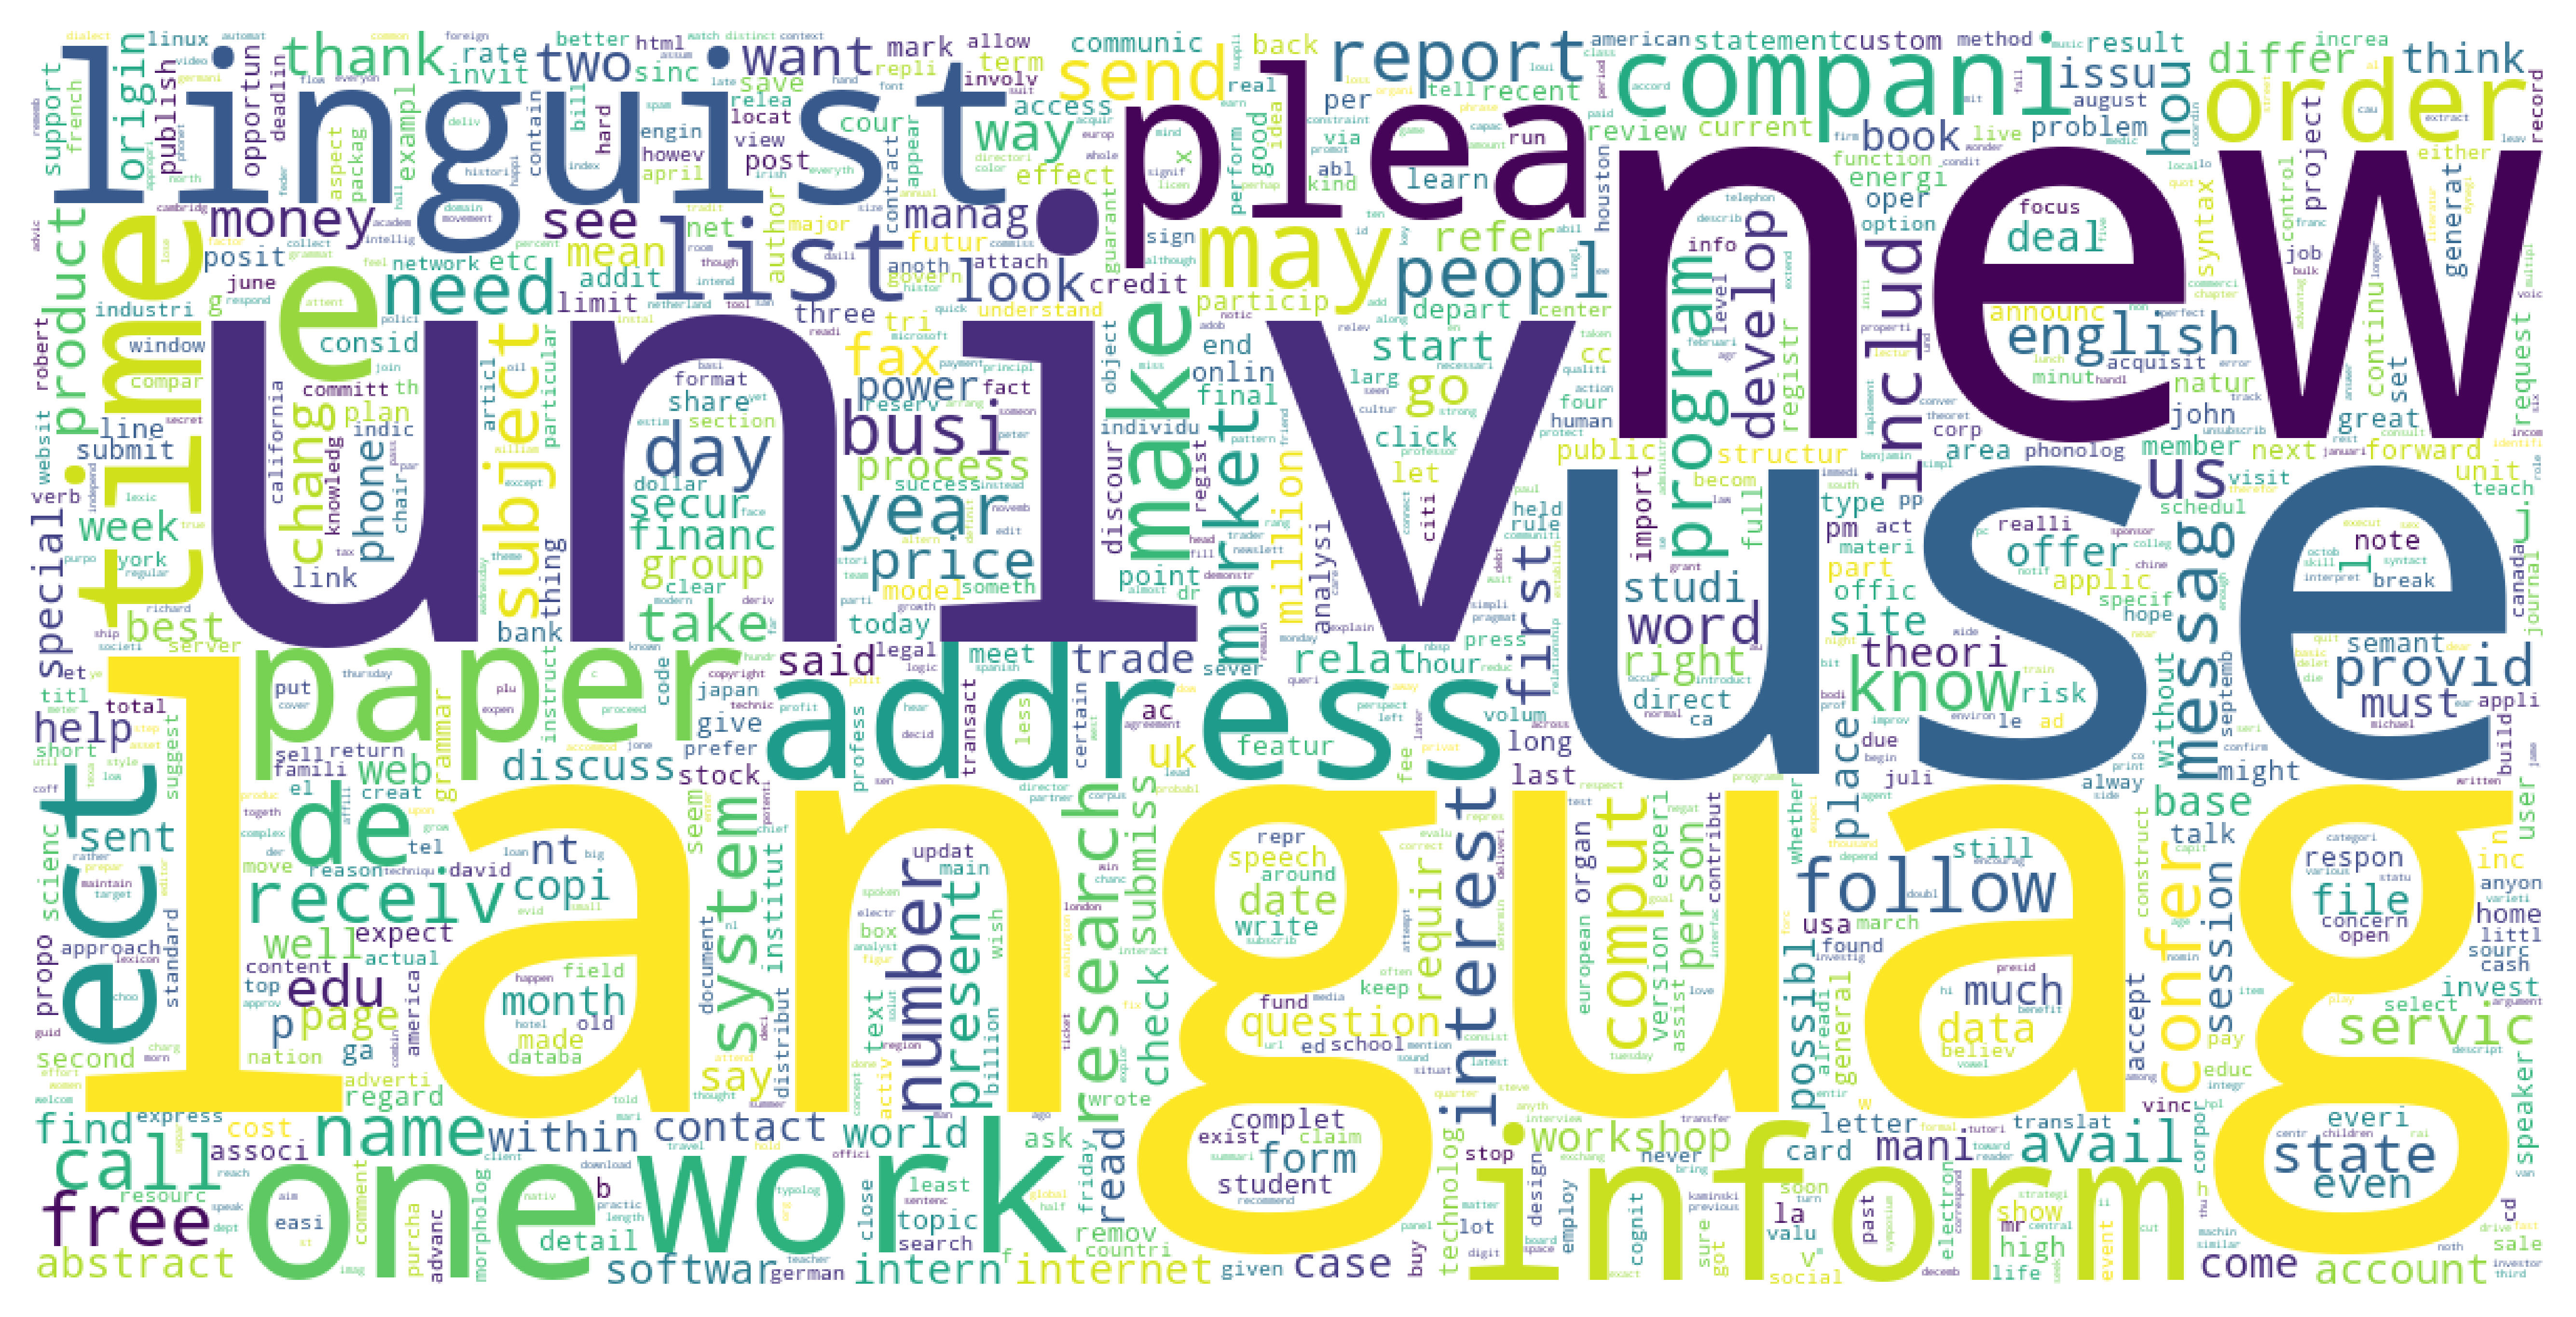

In [26]:
# twitter_mask = np.array(Image.open('/kaggle/input/masksforwordclouds/twitter_mask3.jpg'))

# Configuração da WordCloud
wc = WordCloud(background_color = "white", width = 1200, height = 600,
               contour_width = 0, contour_color = "#410F01", max_words = 1000,
               scale = 1, collocations = False, repeat = True, min_font_size = 1)
              #     mask=twitter_mask)


# Geração da WordCloud
text_data = ' '.join(data for data in df['Email Text Clean'])
wc.generate(text_data)

# Configuração do tamanho da figura
plt.figure(figsize=(10, 7),  dpi=600)

# Configuração da WordCloud na figura
plt.imshow(wc)
plt.axis('off')

# Salvando a imagem com alta resolução
# plt.savefig('img/todos.png')

# Exibição da figura
plt.show()


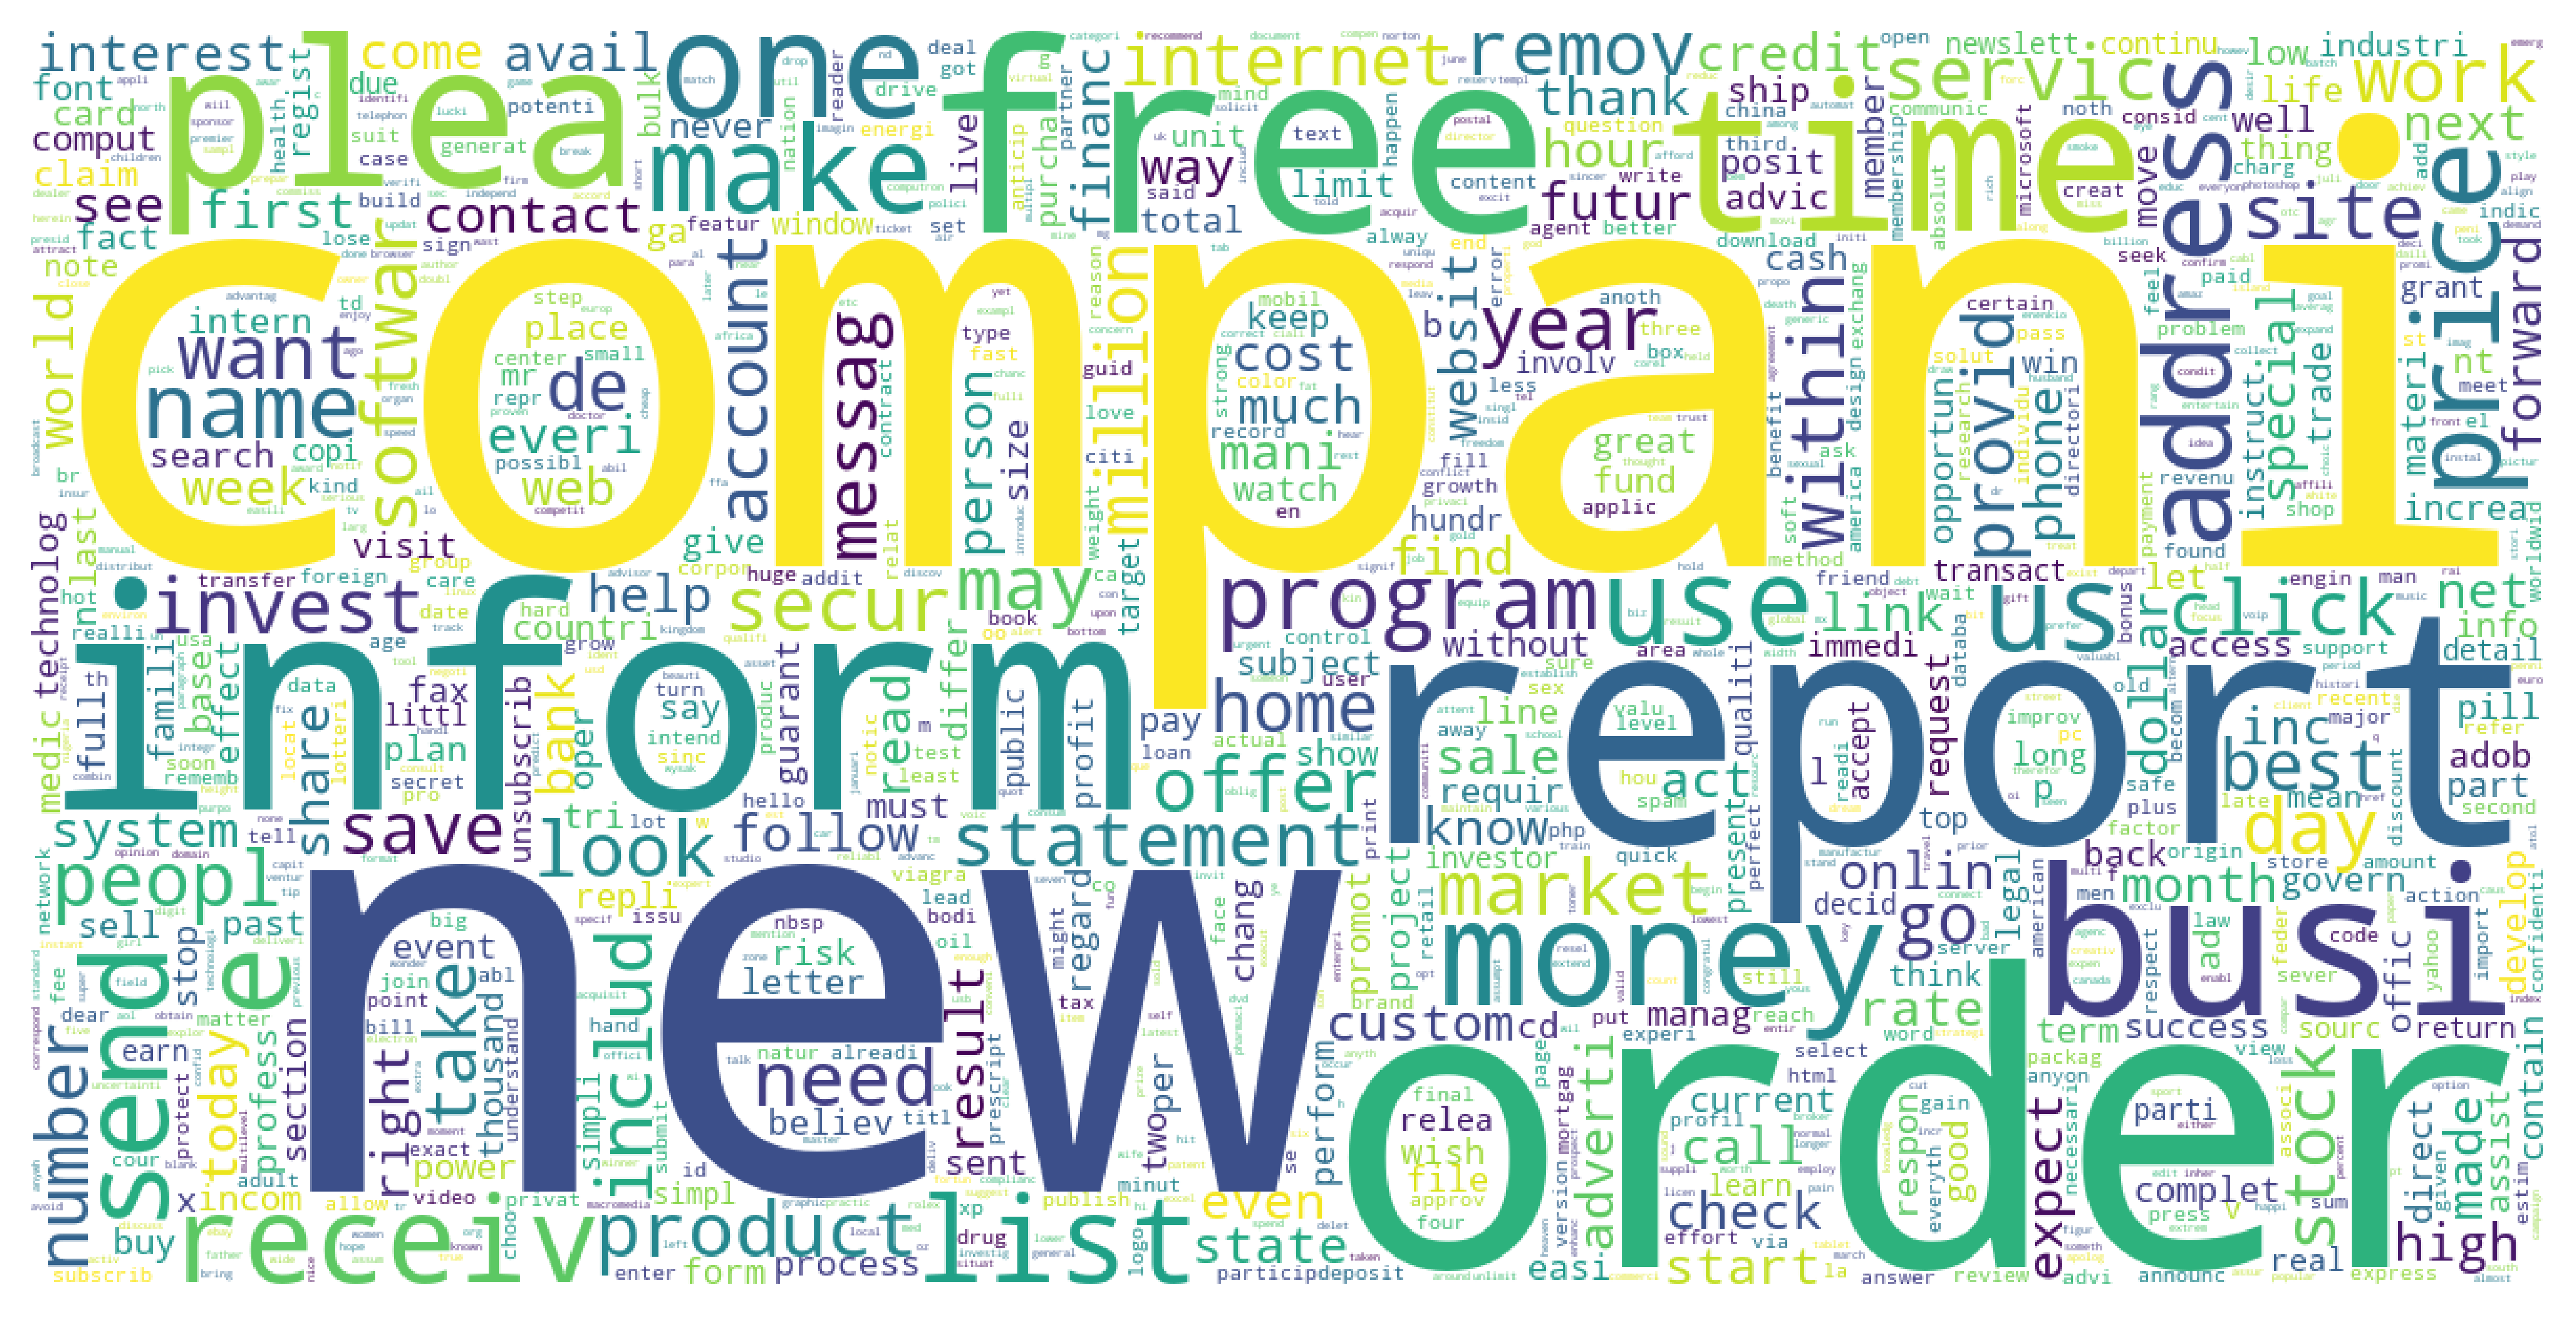

In [27]:
# Geração da WordCloud
text_data = ' '.join(data for data in spam_df['Email Text Clean'])
wc.generate(text_data)

# Configuração do tamanho da figura
plt.figure(figsize=(10, 7), dpi=600)

# Configuração da WordCloud na figura
plt.imshow(wc)
plt.axis('off')

# Salvando a imagem com alta resolução
plt.savefig('img/Phishing.png')

# Exibição da figura
plt.show()

<a id='5'></a>

# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">5. Vetorização e Modelagem</p>

Atualmente, temos as mensagens como listas de tokens (também conhecidos como lemas) e agora precisamos converter cada uma dessas mensagens em um vetor com o qual os modelos de algoritmo do SciKit Learn possam trabalhar.

Faremos isso em três etapas usando diferentes modelos de vetorização:

#### 1. TF-IDF (Term Frequency-Inverse Document Frequency)

- Calcularemos a frequência de termo (TF) para cada palavra em cada mensagem.
- Em seguida, aplicaremos a frequência inversa do documento (IDF) para ponderar as contagens, atribuindo menor peso às palavras frequentes em todo o conjunto de documentos.
- O resultado será uma representação vetorial que captura a importância relativa de cada palavra nas mensagens.

#### 2. Word2Vec

- Usaremos o modelo Word2Vec para representar cada palavra em um espaço vetorial contínuo.
- Para obter a representação vetorial da mensagem, agregaremos as representações vetoriais de todas as palavras presentes na mensagem.
- O Word2Vec captura relações semânticas entre palavras, fornecendo uma representação densa e contextual.

#### 3. BERT (Bidirectional Encoder Representations from Transformers)

- Utilizaremos o modelo BERT para obter representações contextuais de palavras em uma frase.
- A representação vetorial da mensagem será a saída do token [CLS], que captura a informação contextual de toda a frase.
- BERT leva em consideração o contexto bidirecional, proporcionando uma representação mais rica e contextualizada das mensagens.

Vamos começar com o primeiro método: TF-IDF.


In [28]:
# Dividindo os dados em variáveis ​​dependentes e independentes, ou seja, recursos e colunas de Alvo
X=df['Email Text Clean']
Y=df['Email Type Encoded']

# Dividindo os dados de forma que 33% sejam usados para testes e os 67% restantes sejam usados para treinamento.
X_train,X_test,y_train,y_test=train_test_split(X,Y,stratify=Y,test_size=0.33, random_state=42)

<a id='5.1'></a>

# <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">5.1 TF-IDF</p>

Na recuperação de informações, tf–idf, **TF-IDF** ou TFIDF, **abreviação de frequência de termo – frequência inversa de documento**, é uma estatística numérica que se destina a refletir a importância de uma palavra para um documento em uma coleção ou corpus É frequentemente usado como fator de ponderação em pesquisas de recuperação de informações, mineração de texto e modelagem de usuários. O valor tf–idf aumenta proporcionalmente ao número de vezes que uma palavra aparece no documento e é compensado pelo número de documentos no corpus que contém a palavra, o que ajuda a ajustar o fato de que algumas palavras aparecem com mais frequência em geral.

**TF-IDF** é um dos esquemas de ponderação de termos mais populares atualmente. Uma pesquisa realizada em 2015 mostrou que 83% dos sistemas de recomendação baseados em texto em bibliotecas digitais usam TF-IDF.

![tdidf2.png](\img\tdidf2.png)


In [30]:
Tfidf = TfidfVectorizer()

In [31]:
# transformação
X_train_tdidf = Tfidf.fit_transform(X_train)
X_test_tfidf = Tfidf.transform(X_test)

#### RandomForestClassifier


In [32]:
# Treinamento
rf = RandomForestClassifier().fit(X_train_tdidf, y_train)

In [33]:
# Predição
y_pred =rf.predict(X_test_tfidf)

In [34]:
# Acurácia
accuracy_score(y_test,y_pred)

0.9656185210780927

In [36]:
# Matrix confusão
confusion_matrix(y_test,y_pred)

array([[3574,   50],
       [ 149, 2015]], dtype=int64)

In [37]:
# Todas as metricas
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      3624
           1       0.98      0.93      0.95      2164

    accuracy                           0.97      5788
   macro avg       0.97      0.96      0.96      5788
weighted avg       0.97      0.97      0.97      5788



#### LogisticRegression


In [38]:
y_pred = LogisticRegression(random_state=0).fit(X_train_tdidf, y_train).predict(X_test_tfidf)

In [39]:
# Acurácia
accuracy_score(y_test,y_pred)

0.9671734623358673

In [41]:
# Matrix confusão
confusion_matrix(y_test,y_pred)

array([[3564,   60],
       [ 130, 2034]], dtype=int64)

In [42]:
# Todas as metricas
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3624
           1       0.97      0.94      0.96      2164

    accuracy                           0.97      5788
   macro avg       0.97      0.96      0.96      5788
weighted avg       0.97      0.97      0.97      5788



#### Decision Tree


In [43]:
y_pred = DecisionTreeClassifier().fit(X_train_tdidf, y_train).predict(X_test_tfidf)

In [44]:
# Acurácia
accuracy_score(y_test,y_pred)

0.8909813407049068

In [46]:
# Matrix confusão
confusion_matrix(y_test,y_pred)

array([[3285,  339],
       [ 292, 1872]], dtype=int64)

In [47]:
# Todas as metricas
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91      3624
           1       0.85      0.87      0.86      2164

    accuracy                           0.89      5788
   macro avg       0.88      0.89      0.88      5788
weighted avg       0.89      0.89      0.89      5788



<a id='5.2'></a>

# <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px;">5.2 Word2Vec</p>

No contexto da linguagem natural e processamento de texto, **Word2Vec** é uma técnica popular para representação de palavras. Ao contrário do TF-IDF, que se baseia na frequência de termos em documentos, o Word2Vec utiliza redes neurais para criar representações vetoriais de palavras.

A abordagem Word2Vec mapeia palavras para vetores em um espaço contínuo, onde palavras semanticamente similares têm representações vetoriais próximas umas das outras. Isso captura relações semânticas e contextuais entre palavras, permitindo uma compreensão mais profunda das nuances do significado das palavras em um texto. O Word2Vec considera o contexto em que as palavras aparecem. Essa capacidade de levar em conta o contexto torna o Word2Vec valioso em tarefas como análise de sentimentos, agrupamento de documentos e até mesmo na geração de texto.

![word2vec.png](\img\word2vec.png)


In [48]:
# !pip install gensim tensorflow
# !pip install tensorflow
# !pip install contractions

In [49]:
from gensim.models import Word2Vec
import multiprocessing

In [50]:
# Tokenização dos emails
tokenized_train  = [word_tokenize(email) for email in tqdm(X_train)]
tokenized_test  = [word_tokenize(email) for email in tqdm(X_test)]

100%|██████████| 5788/5788 [00:09<00:00, 625.16it/s] 


In [51]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
modelo = Word2Vec(sentences=tokenized_train, vector_size=200,workers=cores-1)

In [52]:
modelo.wv.most_similar('free', topn=10)

[('gift', 0.677852213382721),
 ('lifetim', 0.6500363349914551),
 ('membership', 0.6477745175361633),
 ('bonus', 0.6391015648841858),
 ('absolut', 0.6321512460708618),
 ('signup', 0.6240357160568237),
 ('duti', 0.6125373840332031),
 ('tollfr', 0.6051837801933289),
 ('complimentari', 0.6040099263191223),
 ('on', 0.6018667221069336)]

In [53]:
vocab=list(modelo.wv.key_to_index.keys())
print('Tamanho do vocabulario:', len(vocab))

Tamanho do vocabulario: 21406


In [54]:
def calculate_vector(email, model):
    vectors = [model.wv[word] for word in email if word in model.wv]
    if not vectors:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

In [55]:
x_train_word2vec = [calculate_vector(email, modelo) for email in tokenized_train]
x_test_word2vec = [calculate_vector(email, modelo) for email in tokenized_test]

#### RandomForestClassifier


In [56]:
y_pred = RandomForestClassifier().fit(x_train_word2vec, y_train).predict(x_test_word2vec)

In [57]:
# Acurácia
accuracy_score(y_test,y_pred)

0.9597442985487215

In [59]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3624
           1       0.96      0.93      0.95      2164

    accuracy                           0.96      5788
   macro avg       0.96      0.95      0.96      5788
weighted avg       0.96      0.96      0.96      5788



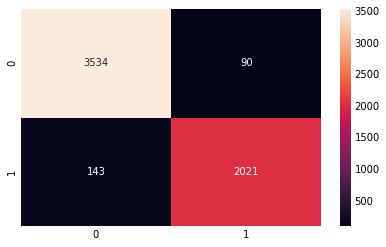

In [60]:
conf_matrix = confusion_matrix(y_test,y_pred)

# Exibir a matriz de confusão sem notação científica
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.show()

#### LogisticRegression


In [61]:
y_pred = LogisticRegression(random_state=0).fit(x_train_word2vec, y_train).predict(x_test_word2vec)

In [62]:
# Acurácia
accuracy_score(y_test,y_pred)

0.948341395991707

In [64]:
# Matrix confusão
confusion_matrix(y_test,y_pred)

array([[3493,  131],
       [ 168, 1996]], dtype=int64)

In [65]:
# Todas as metricas
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      3624
           1       0.94      0.92      0.93      2164

    accuracy                           0.95      5788
   macro avg       0.95      0.94      0.94      5788
weighted avg       0.95      0.95      0.95      5788



#### Decision Tree


In [66]:
y_pred = DecisionTreeClassifier().fit(x_train_word2vec, y_train).predict(x_test_word2vec)

In [67]:
# Acurácia
accuracy_score(y_test,y_pred)

0.9143054595715273

In [69]:
# Matrix confusão
confusion_matrix(y_test,y_pred)

array([[3403,  221],
       [ 275, 1889]], dtype=int64)

In [ ]:
# Todas as metricas
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      2165
           1       0.89      0.88      0.88      2164

    accuracy                           0.88      4329
   macro avg       0.88      0.88      0.88      4329
weighted avg       0.88      0.88      0.88      4329



Conclusão
No caso de detecção de spam, focaremos mais em falsos positivos. Isso ocorre porque, no caso de Falso-Positivo, o modelo irá prever o e-mail não spam como spam, o que resulta na perda de alguns dados úteis. Se o e-mail amador que foi reconhecido como spam contiver alguma informação importante, ela não será entregue ao usuário.
O modelo obtido neste caderno possui muito menos Falsos Positivos quando comparado aos Falsos Negativos.


<a id='5.3'></a>

# <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">5.3. BERT</p>

BERT (Bidirecional Encoder Representations from Transformers) é um artigo recente publicado por pesquisadores do Google AI Language. Ele causou polêmica na comunidade de aprendizado de máquina ao apresentar resultados de última geração em uma ampla variedade de tarefas de PNL, incluindo resposta a perguntas (SQuAD v1.1), inferência de linguagem natural (MNLI) e outras.

A principal inovação técnica do BERT é a aplicação do treinamento bidirecional do Transformer, um modelo de atenção popular, à modelagem de linguagem. Isto contrasta com esforços anteriores que analisaram uma sequência de texto da esquerda para a direita ou um treinamento combinado da esquerda para a direita e da direita para a esquerda. Os resultados do artigo mostram que um modelo de linguagem treinado bidirecionalmente pode ter um senso mais profundo de contexto e fluxo de linguagem do que modelos de linguagem de direção única. No artigo, os pesquisadores detalham uma nova técnica chamada Masked LM (MLM) que permite o treinamento bidirecional em modelos onde antes era impossível.

![bert.png](\img\bert.png)


In [54]:
# !pip install transformers
# !pip install torch

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from transformers import BertTokenizer
# from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

In [207]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
except:
    strategy = tf.distribute.get_strategy()
    
print('Número de réplicas sincronizadas: ', strategy.num_replicas_in_sync)

Número de réplicas sincronizadas:  1


In [208]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,

            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [209]:
texts = df['Email Text Clean']
target = df['Email Type Encoded']

train_input_ids, train_attention_masks = bert_encode(texts,60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [215]:
def create_model(bert_model):
    
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [212]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [216]:
modelo = create_model(bert_model)
modelo.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_5[0][0]',                
                                thPoolingAndCrossAt               'input_6[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                          

In [217]:
history = modelo.fit(
    [train_input_ids, train_attention_masks],
    target,
    validation_split=0.2, 
    epochs=3,
    batch_size=10
)

Epoch 1/3
1050/1050 [==============================] - 4746s 4s/step - loss: 0.2316 - accuracy: 0.9045 - val_loss: 0.2074 - val_accuracy: 0.9337
Epoch 2/3
1050/1050 [==============================] - 4911s 5s/step - loss: 0.0820 - accuracy: 0.9726 - val_loss: 0.0978 - val_accuracy: 0.9684
Epoch 3/3
1050/1050 [==============================] - 4701s 4s/step - loss: 0.0421 - accuracy: 0.9864 - val_loss: 0.1191 - val_accuracy: 0.9623


In [6]:
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb

In [265]:
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

In [266]:
Safe_Email = df[df[1]== 0]
Phishing_Email = df[df[1]== 1]
Safe_Email = Safe_Email.sample(90)
df = pd.concat([Safe_Email, Phishing_Email], ignore_index = True)

In [267]:
batch_1 = df.sample(2000)

In [268]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')


# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [269]:
tokenized = batch_1[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [270]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [271]:
np.array(padded).shape

(2000, 64)

In [272]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2000, 64)

In [273]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [274]:
features = last_hidden_states[0][:,0,:].numpy()
# labels = batch_1['Email Type Encode']
labels = batch_1[1]
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=.3)

#### RandomForestClassifier


In [275]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [276]:
y_pred = rf.predict(X_test)
# Todas as metricas
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.98      1.00      0.99       587

    accuracy                           0.98       600
   macro avg       0.49      0.50      0.49       600
weighted avg       0.96      0.98      0.97       600



#### LogisticRegression


In [259]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [260]:
y_pred = lr.predict(X_test)
# Todas as metricas
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.97      1.00      0.98       584

    accuracy                           0.97       600
   macro avg       0.49      0.50      0.49       600
weighted avg       0.95      0.97      0.96       600



#### DecisionTreeClassifier


In [262]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [263]:
y_pred = dt.predict(X_test)
# Todas as metricas
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.97      0.97      0.97       584

    accuracy                           0.94       600
   macro avg       0.49      0.48      0.49       600
weighted avg       0.95      0.94      0.94       600

